In [21]:
%run ../nn_option_pricer/_key_imports.py
import sys

sys.path.append("../")
from nn_option_pricer.bergomi import bergomi_eval_wrapper, bergomi_model_inference
from nn_option_pricer.nn_archi import *
from nn_option_pricer.utils import diagnosis_hedge, visualise_surface, trainable_params
%run ../nn_option_pricer/default_config.py

$\sigma^{2}(X)\tau = \mathbb{E}[\sqrt{\int_{t}^{T} \sigma_{t}^{2} dt}]$

$S_{t} = \sigma_{t} S_{t}dW_{t}, S_{t} = S_{0}\exp(-\frac{1}{2}\int_{t}^{T} \sigma_{t}^{2} dt + \sigma )$

In [22]:
targets = ["alpha", "rho", "vol-of-vol", "vol_0"]
feat_names = ["MC_call", "MC_digital", "ttm", "log-strike"]
dataset_name = "rough_bergomi"



N_FEATS = len(feat_names)
f_to_i = lambda x: feat_names.index(x)

t_to_i = lambda x: targets.index(x)


X_df_train = pd.read_csv(f"datasets/{dataset_name}_train.csv")
Xs_train = X_df_train[feat_names].values
ys_train = X_df_train[targets]
mins, maxs = ys_train.min(), ys_train.max()
# ys_train = 2 * (ys_train - 0.5 * (mins + maxs)) / (maxs - mins)
ys_train = (ys_train - mins) / (maxs - mins)

X_df_test = pd.read_csv(f"datasets/{dataset_name}_test.csv")
Xs_test = X_df_test[feat_names].values
ys_test = X_df_test[targets]
# ys_test = 2 * (ys_test - 0.5 * (mins + maxs)) / (maxs - mins)
ys_test = (ys_tests - mins) / (maxs - mins)

all_res = []

all_model_preds = {}
all_model_grads = {}
all_model_hessian = {}
all_models = {}

from itertools import product
col_names = [f"d_{x[1]}/d_{x[0]}" for x in list(product(feat_names, targets))]

In [23]:
nn_params["n_feats"] = len(feat_names)
nn_params["output_dim"] = len(targets)
fit_params["batch_size"] = 1024
LR = 1e-4
fit_params["epochs"] = 100
nn_params["hidden_units"] = 256
nn_params["n_layers"] = 2
nn_params["hidden_act"] = "swish"
nn_params["output_act"] = "sigmoid"
compile_params['metrics'] +=  [tf.keras.losses.MeanAbsolutePercentageError(name="MAPE")]
metric_names += ["MAPE"]
compile_params['loss'] = tf.keras.losses.MeanAbsoluteError()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 4)]               0         
                                                                 
 batch_normalization_12 (Bat  (None, 4)                16        
 chNormalization)                                                
                                                                 
 dense_12 (Dense)            (None, 256)               1280      
                                                                 
 batch_normalization_13 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dense_13 (Dense)            (None, 256)               65792     
                                                                 
 batch_normalization_14 (Bat  (None, 256)              1024

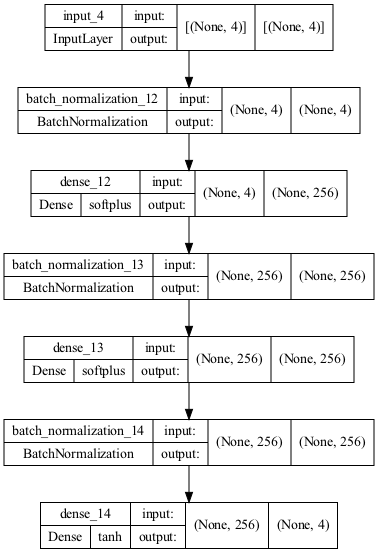

Training:   0%|                                        0/100 ETA: ?s,  ?epochs/s

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 batch_normalization_15 (BatchN  (None, 4)           16          ['input_5[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 dense_15 (Dense)               (None, 256)          1280        ['batch_normalization_15[0][0]'] 
                                                                                                  
 batch_normalization_16 (BatchN  (None, 256)         1024        ['dense_15[0][0]']         

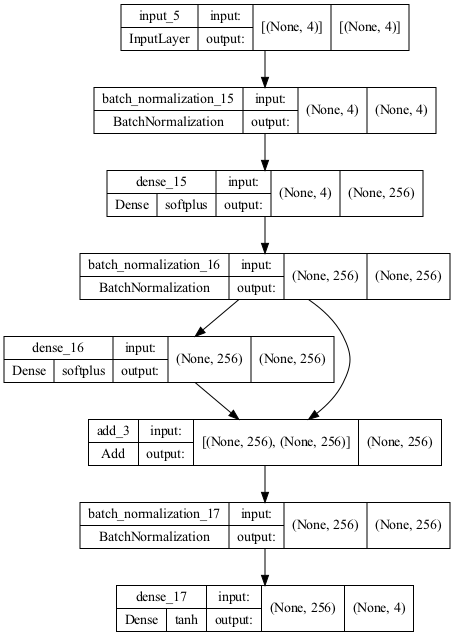

Training:   0%|                                        0/100 ETA: ?s,  ?epochs/s

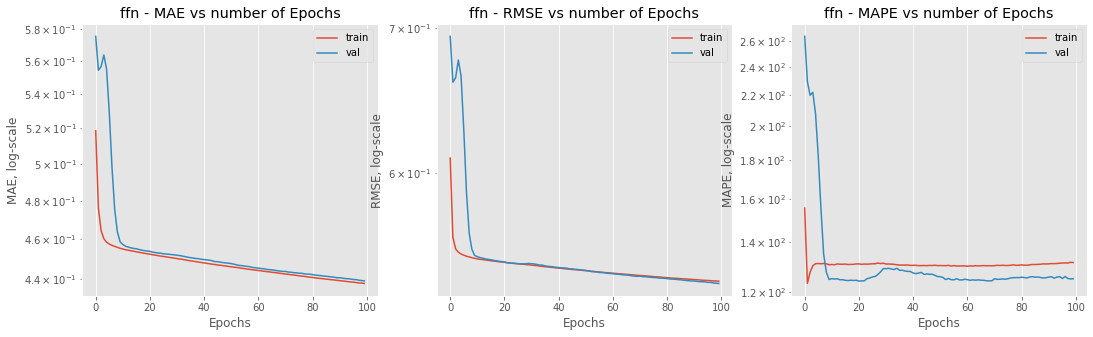

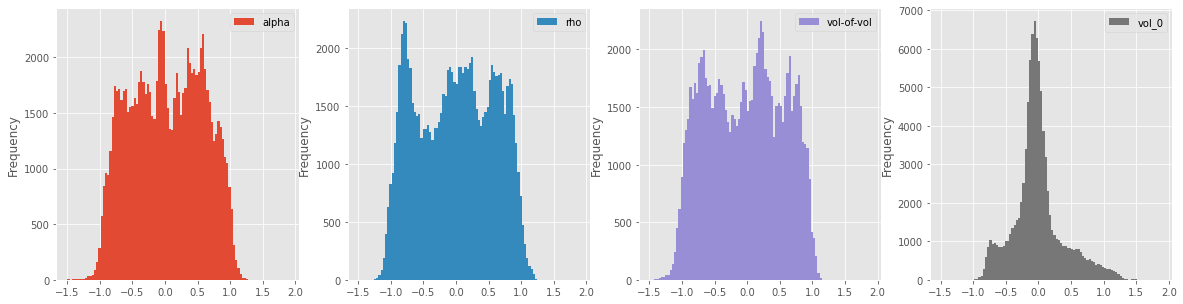

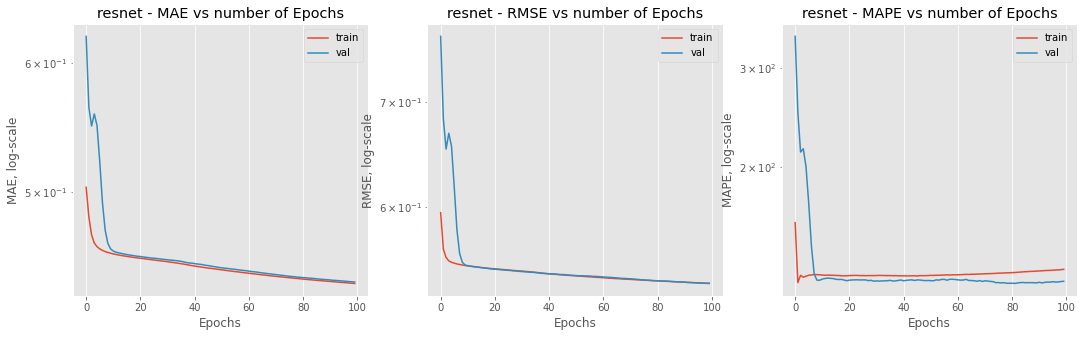

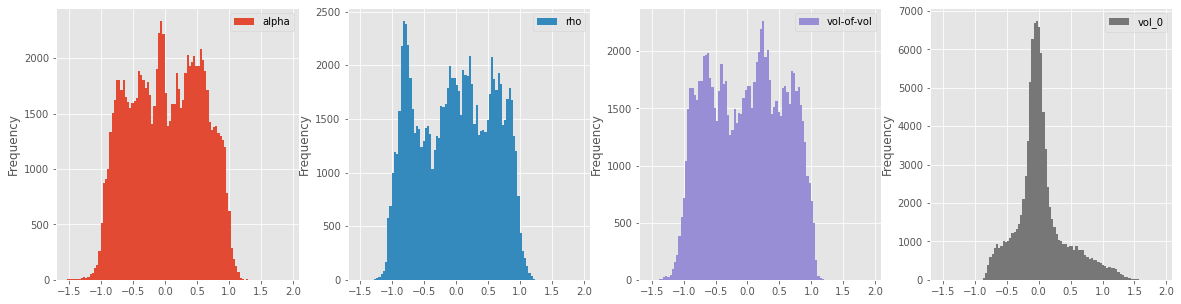

In [24]:
for METHOD in ["ffn", "resnet"]:
    if METHOD == "ffn":
        all_models[METHOD] = make_model(**nn_params)

    elif METHOD == "resnet":
        nn_params2 = nn_params.copy()
        nn_params2['resnet'] = True
        all_models[METHOD] = make_model(**nn_params2)
    
    all_models[METHOD].compile(optimizer=tf.keras.optimizers.Adam(learning_rate = LR), **compile_params)
    all_models[METHOD].summary()
    display(tf.keras.utils.plot_model(
        all_models[METHOD], show_layer_activations=True, show_shapes=True, dpi=72
    ))
    train_time, history = train_nn(all_models[METHOD], Xs_train, ys_train, fit_params, metric_names, METHOD)
    
    start = time.time()
    X_tensor = tf.Variable(Xs_test)
    with tf.GradientTape() as tape:
        output = all_models[METHOD](X_tensor)
        grad  = tape.batch_jacobian(output, X_tensor)
    inf_time = time.time() - start
    all_model_grads[METHOD] = pd.DataFrame(grad.numpy().reshape((-1, 16)), columns = col_names)
    
    pred_test = output.numpy()
    fig, ax = plt.subplots(ncols = len(targets), figsize=(len(targets ) * 5, 5))
    (ys_test - pred_test).plot(kind='hist',subplots = True, ax= ax, bins = 100)


    
    
    temp_arr = [pd.DataFrame({"all_mse":tf.keras.losses.MeanSquaredError()(ys_test, pred_test).numpy(),
                              "all_mae":tf.keras.losses.MeanAbsoluteError()(ys_test, pred_test).numpy(),
                              "all_mape":tf.keras.losses.MeanAbsolutePercentageError()(ys_test, pred_test).numpy(),
                              "train_time": train_time, 
                              "model_parameters":trainable_params(all_models[METHOD]),
                              "inf_time": inf_time}, index=[METHOD])]
    temp_arr += [pd.DataFrame({f"{x}_mse":tf.keras.losses.MeanSquaredError()(ys_test[x], pred_test[:, t_to_i(x)]).numpy() for x in targets}, index=[METHOD])]
    temp_arr +=[pd.DataFrame({f"{x}_mae":tf.keras.losses.MeanAbsoluteError()(ys_test[x], pred_test[:, t_to_i(x)]).numpy() for x in targets}, index=[METHOD])]
    
    temp = pd.concat(temp_arr, axis = 1)
    all_res += [temp.copy()]

In [53]:
pd.concat(all_res)

,all_mse,all_mae,all_mape,train_time,model_parameters,inf_time,alpha_mse,rho_mse,vol-of-vol_mse,vol_0_mse,alpha_mae,rho_mae,vol-of-vol_mae,vol_0_mae
ffn,0.283111,0.437683,127.961998,125.154741,69132,3.264310,0.302828,0.346874,0.334820,0.147920,0.471866,0.506134,0.499336,0.273394
resnet,0.285535,0.438486,127.722473,119.802861,69132,3.292287,0.305471,0.345613,0.334739,0.156317,0.474595,0.504958,0.499684,0.274709
poly_reg_vol_0,0.227555,0.376041,145.291031,7.279474,715,3.292287,0.224175,0.307633,0.288661,0.089751,0.389951,0.468564,0.457601,0.188049
poly_reg,0.227555,0.376041,145.291031,7.279474,715,3.292287,0.224175,0.307633,0.288661,0.089751,0.389951,0.468564,0.457601,0.188049
poly_reg,0.227555,0.376041,145.291031,7.279474,715,3.292287,0.224175,0.307633,0.288661,0.089751,0.389951,0.468564,0.457601,0.188049


In [58]:
all_res_df = pd.concat(all_res).reset_index().drop_duplicates(subset=['index'],keep='last').set_index("index").T
display(all_res_df.style.background_gradient(axis = 1))
all_res_df.to_csv("results/calibration.csv")

index,ffn,resnet,poly_reg
all_mse,0.283111,0.285535,0.227555
all_mae,0.437683,0.438486,0.376041
all_mape,127.961998,127.722473,145.291031
train_time,125.154741,119.802861,7.279474
model_parameters,69132.000000,69132.000000,715.000000
inf_time,3.264310,3.292287,3.292287
alpha_mse,0.302828,0.305471,0.224175
rho_mse,0.346874,0.345613,0.307633
vol-of-vol_mse,0.334820,0.334739,0.288661
vol_0_mse,0.147920,0.156317,0.089751


In [29]:
import math
degree = round((math.factorial(N_FEATS) * (nn_params["hidden_units"])) ** (1/ N_FEATS))
from nn_option_pricer.poly_reg import train_infer_poly

train_times  = []
inference_times  = []
for x in tqdm(targets):
    METHOD = f"poly_reg_{x}"
    train_time, inference_time = train_infer_poly(degree, Xs_train, 
                                                  ys_train[x], 
                                                  Xs_test, 
                                                  ys_test[x], 
                                                  feat_names, 
                                                  all_models, 
                                                  all_model_preds, 
                                                  all_model_grads, 
                                                  all_model_hessian, 
                                                  f_to_i, 
                                                  moneyness_var = "MC_call", 
                                                  METHOD=METHOD, eps=1e-4)
    train_times += [train_time]
    inference_times += [inference_time]

  0%|          | 0/4 [00:00<?, ?it/s]

In [35]:
pred_test = pd.DataFrame({x : all_model_preds[f"poly_reg_{x}"] for x in targets}).values

In [37]:
temp_arr = [pd.DataFrame({"all_mse":tf.keras.losses.MeanSquaredError()(ys_test, pred_test).numpy(),
                              "all_mae":tf.keras.losses.MeanAbsoluteError()(ys_test, pred_test).numpy(),
                              "all_mape":tf.keras.losses.MeanAbsolutePercentageError()(ys_test, pred_test).numpy(),
                              "train_time": train_time, 
                              "model_parameters":len(all_models[METHOD]['lr'].coef_),
                              "inf_time": inf_time}, index=[METHOD])]
temp_arr += [pd.DataFrame({f"{x}_mse":tf.keras.losses.MeanSquaredError()(ys_test[x], pred_test[:, t_to_i(x)]).numpy() for x in targets}, index=[METHOD])]
temp_arr +=[pd.DataFrame({f"{x}_mae":tf.keras.losses.MeanAbsoluteError()(ys_test[x], pred_test[:, t_to_i(x)]).numpy() for x in targets}, index=[METHOD])]

In [49]:
temp = pd.concat(temp_arr, axis = 1).copy()
temp.index = ['poly_reg']
all_res += [temp.copy()]

<AxesSubplot:xlabel='MC_call', ylabel='d_vol_0/d_MC_call'>

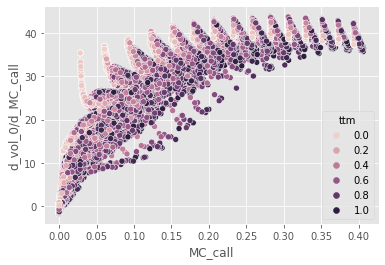

In [51]:
METHOD = "ffn"
sns.scatterplot(x = X_df_test["MC_call"], y = all_model_grads[METHOD]["d_vol_0/d_MC_call"], hue = X_df_test['ttm'])